In [1]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pandas as pd

from utilities import fuse_landmarks_from_two_cameras, convert_to_left_shoulder_coord
from functools import partial
from ann import ANN

import open3d as o3d
from utilities import convert_to_left_shoulder_coord
import time

from csv_writer import columns_to_normalize, fusion_csv_columns_name
from landmarks_scaler import LandmarksScaler

from left_arm_angle_calculator import LeftArmAngleCalculator
from left_hand_angle_calculator import LeftHandAngleCalculator

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

In [3]:
left_arm_angle_calculator = LeftArmAngleCalculator(
    num_chain=3, 
    landmark_dictionary=arm_hand_fused_names)
left_hand_angle_calculator = LeftHandAngleCalculator(
    num_chain=2, 
    landmark_dictionary=arm_hand_fused_names)

In [4]:
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "*"

MODEL_DATE = "20241017"
MODEL_TIME = "2032"
NUM_HIDDEN_LAYERS = 4

In [5]:
train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "train")))
val_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "val")))
test_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "test")))
body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
train_body_distance_thres = 550
train_leftarm_distance_thres = 550
train_lefthand_distance_thres = 200
val_body_distance_thres=450,
val_leftarm_distance_thres=450,
val_lefthand_distance_thres=150,

scaler_path = "/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand/runs/ann/{}/{}-{}/input_scaler.pkl".format(MODEL_DATE, MODEL_DATE, MODEL_TIME)
landmarks_scaler = LandmarksScaler(columns_to_scale=columns_to_normalize,
    scaler_path=scaler_path)

train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    scaler=landmarks_scaler,
    cvt_normalized_xy_to_XY=True)
val_dataset = HandArmLandmarksDataset_ANN(val_paths,
    body_lines,
    lefthand_lines,
    val_body_distance_thres,
    val_leftarm_distance_thres,
    val_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    scaler=landmarks_scaler,
    cvt_normalized_xy_to_XY=True)
test_dataset = HandArmLandmarksDataset_ANN(test_paths,
    body_lines,
    lefthand_lines,
    val_body_distance_thres,
    val_leftarm_distance_thres,
    val_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    scaler=landmarks_scaler,
    cvt_normalized_xy_to_XY=True)

In [6]:
input_data = train_dataset._inputs
input_data.shape

(10278, 288)

In [7]:
ground_truth_data = train_dataset._outputs
ground_truth_data = ground_truth_data.reshape(-1, 3, 48)
ground_truth_data = np.transpose(ground_truth_data, (0, 2, 1))
ground_truth_data.shape

(10278, 48, 3)

In [8]:
input_dim = 288
output_dim = 144
hidden_dim = int(144 + (144 / 2))
num_hidden_layers = NUM_HIDDEN_LAYERS
dropout_rate = 0.1
model_weight_path = "/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand/runs/ann/{}/{}-{}/ann_{}_layers_best.pth".format(
    MODEL_DATE, MODEL_DATE, MODEL_TIME, NUM_HIDDEN_LAYERS)
#model_weight_path = "/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand/runs/ann/{}/{}-{}/ann_best.pth".format(
    #MODEL_DATE, MODEL_DATE, MODEL_TIME)

ann_model = ANN(input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_hidden_layers=num_hidden_layers,
    dropout_rate=dropout_rate
)

ann_model.load_state_dict(torch.load(model_weight_path))
ann_model.to("cuda")
ann_model.eval()

/tmp/ipykernel_10570/4170716555.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann_model.load_state_dict(torch.load(model_weight_path))


ANN(
  (network): Sequential(
    (0): Linear(in_features=288, out_features=216, bias=True)
    (1): BatchNorm1d(216, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=216, out_features=216, bias=True)
    (4): BatchNorm1d(216, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=216, out_features=216, bias=True)
    (7): BatchNorm1d(216, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): Tanh()
    (9): Linear(in_features=216, out_features=216, bias=True)
    (10): BatchNorm1d(216, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): Tanh()
    (12): Linear(in_features=216, out_features=216, bias=True)
    (13): BatchNorm1d(216, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): Tanh()
    (15): Linear(in_features=216, out_features=144, bias=True)
    (16): BatchNorm1d(144, eps=1e-05, momentum=0.1, affin

In [9]:
input_row = torch.Tensor(input_data)
input_row = input_row.to("cuda")

In [10]:
pred_output = ann_model(input_row)

In [11]:
pred_output = pred_output.detach().to("cpu").numpy()
pred_output = pred_output.reshape(-1, 3, 48)
pred_output = np.transpose(pred_output, (0, 2, 1))
pred_output.shape

(10278, 48, 3)

In [12]:
ground_truth_data.shape

(10278, 48, 3)

In [13]:
mae_of_first_26_joints = np.average(np.abs(ground_truth_data[:, :26, :] - pred_output[:, :26, :]))
print("Mean abs. error of the first 26 joints: {}(mm)".format(round(mae_of_first_26_joints, 2)))

Mean abs. error of the first 26 joints: 40.33(mm)


In [14]:
pred_output = pred_output[:, :26, :]
print(pred_output.shape)

(10278, 26, 3)


In [15]:
ground_truth_data = ground_truth_data[:, :26, :]
print(ground_truth_data.shape)

(10278, 26, 3)


In [16]:
pred_angles = []

for i in range(pred_output.shape[0]):
    output = pred_output[i]
    train_pred_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
        output,
        arm_hand_fused_names)
    
    left_arm_result = left_arm_angle_calculator(train_pred_XYZ_wrt_shoulder, 
        parent_coordinate=xyz_origin)
    left_arm_angles = left_arm_result["left_arm"]["angles"]
    left_arm_rot_mats_wrt_origin = left_arm_result["left_arm"]["rot_mats_wrt_origin"]
    last_coordinate_from_left_arm = left_arm_rot_mats_wrt_origin[-1]
    left_hand_result = left_hand_angle_calculator(train_pred_XYZ_wrt_shoulder, 
        parent_coordinate=last_coordinate_from_left_arm)
    
    left_hand_angles = []
    for finger_name in left_hand_angle_calculator.fingers_name:
        finger_i_angles = left_hand_result[finger_name]["angles"].copy()

        # In robot, its finger joint 1 is our finger joint 2, and vice versa (EXCEPT FOR THUMB FINGER). 
        # So that, we need to swap these values.
        if finger_name != "THUMB":
            finger_i_angles[0], finger_i_angles[1] = finger_i_angles[1], finger_i_angles[0]

        left_hand_angles.extend(finger_i_angles)
    
    angles = left_arm_angles.copy()
    angles.extend(left_hand_angles)    
    pred_angles.append(angles)

pred_angles = np.array(pred_angles)

In [17]:
gt_angles = []

for i in range(ground_truth_data.shape[0]):
    gt = ground_truth_data[i]
    train_gt_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
        gt,
        arm_hand_fused_names)
    
    left_arm_result = left_arm_angle_calculator(train_gt_XYZ_wrt_shoulder, 
        parent_coordinate=xyz_origin)
    left_arm_angles = left_arm_result["left_arm"]["angles"]
    left_arm_rot_mats_wrt_origin = left_arm_result["left_arm"]["rot_mats_wrt_origin"]
    last_coordinate_from_left_arm = left_arm_rot_mats_wrt_origin[-1]
    left_hand_result = left_hand_angle_calculator(train_gt_XYZ_wrt_shoulder, 
        parent_coordinate=last_coordinate_from_left_arm)
    
    left_hand_angles = []
    for finger_name in left_hand_angle_calculator.fingers_name:
        finger_i_angles = left_hand_result[finger_name]["angles"].copy()

        # In robot, its finger joint 1 is our finger joint 2, and vice versa (EXCEPT FOR THUMB FINGER). 
        # So that, we need to swap these values.
        if finger_name != "THUMB":
            finger_i_angles[0], finger_i_angles[1] = finger_i_angles[1], finger_i_angles[0]

        left_hand_angles.extend(finger_i_angles)
    
    angles = left_arm_angles.copy()
    angles.extend(left_hand_angles)    
    gt_angles.append(angles)

gt_angles = np.array(gt_angles)

In [18]:
angles_errors = np.mean(np.abs(gt_angles - pred_angles), axis=0)

In [19]:
angles_names = ["left_arm_joint_01",
                "left_arm_joint_02",
                "left_arm_joint_03",
                "left_arm_joint_04",
                "left_arm_joint_05",
                "left_arm_joint_06",
                "left_THUMB_joint_01",
                "left_THUMB_joint_02",
                "left_THUMB_joint_03",
                "left_INDEX_joint_01",
                "left_INDEX_joint_02",
                "left_INDEX_joint_03",
                "left_MIDDLE_joint_01",
                "left_MIDDLE_joint_02",
                "left_MIDDLE_joint_03",
                "left_RING_joint_01",
                "left_RING_joint_02",
                "left_RING_joint_03",
                "left_PINKY_joint_01",
                "left_PINKY_joint_02",
                "left_PINKY_joint_03"]

In [20]:
assert len(angles_names) == len(angles_errors)

for joint_error, joint_name in zip(angles_errors, angles_names):
    print(f"{joint_name} mean error: {round(joint_error, 2)}")

left_arm_joint_01 mean error: 8.95
left_arm_joint_02 mean error: 7.84
left_arm_joint_03 mean error: 18.32
left_arm_joint_04 mean error: 11.7
left_arm_joint_05 mean error: 37.66
left_arm_joint_06 mean error: 13.99
left_THUMB_joint_01 mean error: 14.29
left_THUMB_joint_02 mean error: 15.96
left_THUMB_joint_03 mean error: 6.2
left_INDEX_joint_01 mean error: 14.09
left_INDEX_joint_02 mean error: 15.71
left_INDEX_joint_03 mean error: 20.76
left_MIDDLE_joint_01 mean error: 15.89
left_MIDDLE_joint_02 mean error: 17.56
left_MIDDLE_joint_03 mean error: 23.58
left_RING_joint_01 mean error: 16.73
left_RING_joint_02 mean error: 18.13
left_RING_joint_03 mean error: 23.48
left_PINKY_joint_01 mean error: 17.32
left_PINKY_joint_02 mean error: 20.45
left_PINKY_joint_03 mean error: 20.76


In [13]:
output_columns_name = np.array(fusion_csv_columns_name[-144:])
output_columns_name = np.reshape(output_columns_name, (3, 48))

Visualize box plots from *left_shoulder -> right_elbow* (27 joints in total)

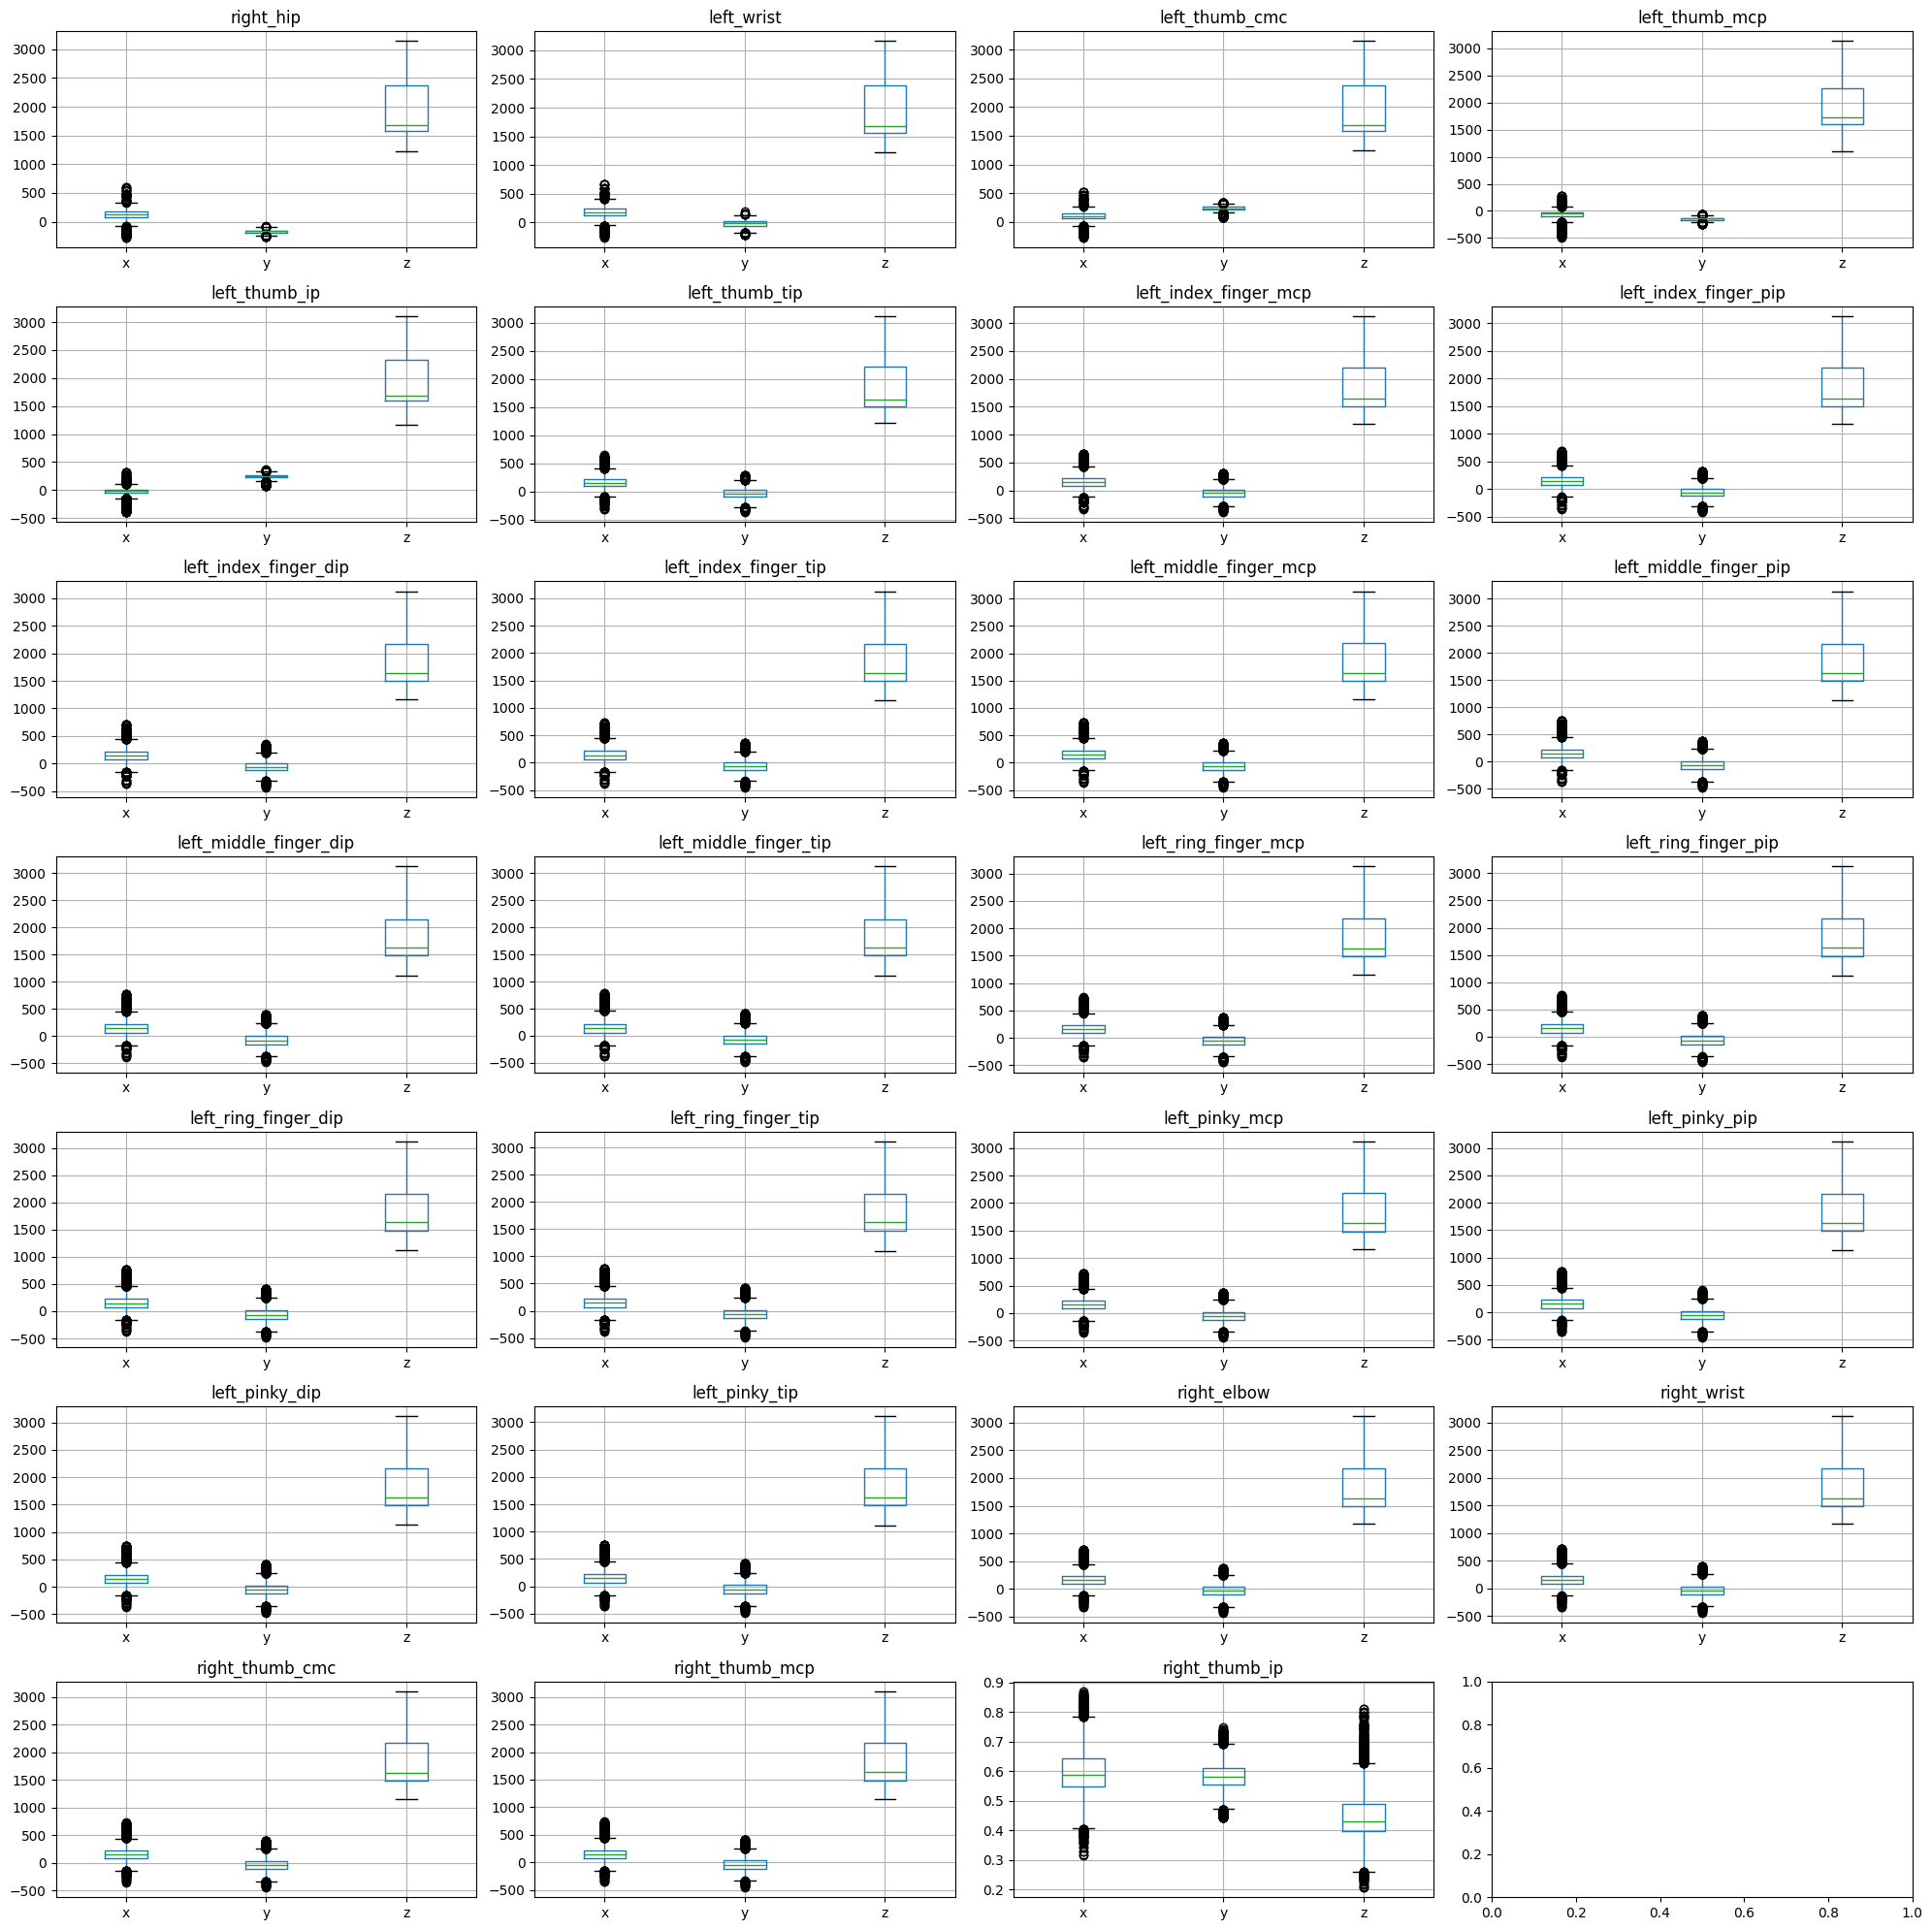

In [15]:
fig, axes = plt.subplots(7, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(len(arm_hand_fused_names)):
    ax = axes[i]
    df = pd.DataFrame(pred_output[:, i, :], columns=output_columns_name[:, i])
    df.boxplot(ax=ax)
    title = output_columns_name[:, i][0].split("_output")[0]
    ax.set_title(title)
    ax.set_xticklabels(["x", "y", "z"])

plt.tight_layout()
plt.show()

In [16]:
target_output = train_dataset._outputs  # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_left_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

KeyboardInterrupt: 

: 

In [14]:
target_output = ann_model(input_row).detach().to("cpu").numpy() # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_left_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

KeyboardInterrupt: 

# Inspect val set

In [28]:
val_input = val_dataset._inputs
val_input.shape

(2379, 288)

In [29]:
val_gt = val_dataset._outputs
val_gt = val_gt.reshape(-1, 3, 48)
val_gt = np.transpose(val_gt, (0, 2, 1))
val_gt.shape

(2379, 48, 3)

In [30]:
val_input = torch.Tensor(val_input)
val_input = val_input.to("cuda")
val_preds = ann_model(val_input)
val_preds = val_preds.detach().to("cpu").numpy()
val_preds = val_preds.reshape(-1, 3, 48)
val_preds = np.transpose(val_preds, (0, 2, 1))
val_preds.shape

(2379, 48, 3)

In [31]:
mae_of_first_26_joints = np.average(np.abs(val_gt[:, :26, :] - val_preds[:, :26, :]))
print("Mean abs. error of the first 26 joints: {}(mm)".format(round(mae_of_first_26_joints, 2)))

Mean abs. error of the first 26 joints: 15.81(mm)


In [33]:
val_preds = val_preds[:, :26, :]
print(val_preds.shape)

(2379, 26, 3)


In [35]:
val_gt = val_gt[:, :26, :]
print(val_gt.shape)

(2379, 26, 3)


In [36]:
pred_angles = []

for i in range(val_preds.shape[0]):
    val_pred = val_preds[i]
    val_pred_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
        val_pred,
        arm_hand_fused_names)
    
    left_arm_result = left_arm_angle_calculator(val_pred_XYZ_wrt_shoulder, 
        parent_coordinate=xyz_origin)
    left_arm_angles = left_arm_result["left_arm"]["angles"]
    left_arm_rot_mats_wrt_origin = left_arm_result["left_arm"]["rot_mats_wrt_origin"]
    last_coordinate_from_left_arm = left_arm_rot_mats_wrt_origin[-1]
    left_hand_result = left_hand_angle_calculator(val_pred_XYZ_wrt_shoulder, 
        parent_coordinate=last_coordinate_from_left_arm)
    
    left_hand_angles = []
    for finger_name in left_hand_angle_calculator.fingers_name:
        finger_i_angles = left_hand_result[finger_name]["angles"].copy()

        # In robot, its finger joint 1 is our finger joint 2, and vice versa (EXCEPT FOR THUMB FINGER). 
        # So that, we need to swap these values.
        if finger_name != "THUMB":
            finger_i_angles[0], finger_i_angles[1] = finger_i_angles[1], finger_i_angles[0]

        left_hand_angles.extend(finger_i_angles)
    
    angles = left_arm_angles.copy()
    angles.extend(left_hand_angles)    
    pred_angles.append(angles)

pred_angles = np.array(pred_angles)

In [37]:
gt_angles = []

for i in range(val_gt.shape[0]):
    gt = val_gt[i]
    val_gt_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
        gt,
        arm_hand_fused_names)
    
    left_arm_result = left_arm_angle_calculator(val_gt_XYZ_wrt_shoulder, 
        parent_coordinate=xyz_origin)
    left_arm_angles = left_arm_result["left_arm"]["angles"]
    left_arm_rot_mats_wrt_origin = left_arm_result["left_arm"]["rot_mats_wrt_origin"]
    last_coordinate_from_left_arm = left_arm_rot_mats_wrt_origin[-1]
    left_hand_result = left_hand_angle_calculator(val_gt_XYZ_wrt_shoulder, 
        parent_coordinate=last_coordinate_from_left_arm)
    
    left_hand_angles = []
    for finger_name in left_hand_angle_calculator.fingers_name:
        finger_i_angles = left_hand_result[finger_name]["angles"].copy()

        # In robot, its finger joint 1 is our finger joint 2, and vice versa (EXCEPT FOR THUMB FINGER). 
        # So that, we need to swap these values.
        if finger_name != "THUMB":
            finger_i_angles[0], finger_i_angles[1] = finger_i_angles[1], finger_i_angles[0]

        left_hand_angles.extend(finger_i_angles)
    
    angles = left_arm_angles.copy()
    angles.extend(left_hand_angles)    
    gt_angles.append(angles)

gt_angles = np.array(gt_angles)

In [38]:
angles_errors = np.mean(np.abs(gt_angles - pred_angles), axis=0)

In [39]:
angles_names = ["left_arm_joint_01",
                "left_arm_joint_02",
                "left_arm_joint_03",
                "left_arm_joint_04",
                "left_arm_joint_05",
                "left_arm_joint_06",
                "left_THUMB_joint_01",
                "left_THUMB_joint_02",
                "left_THUMB_joint_03",
                "left_INDEX_joint_01",
                "left_INDEX_joint_02",
                "left_INDEX_joint_03",
                "left_MIDDLE_joint_01",
                "left_MIDDLE_joint_02",
                "left_MIDDLE_joint_03",
                "left_RING_joint_01",
                "left_RING_joint_02",
                "left_RING_joint_03",
                "left_PINKY_joint_01",
                "left_PINKY_joint_02",
                "left_PINKY_joint_03"]

In [40]:
assert len(angles_names) == len(angles_errors)

for joint_error, joint_name in zip(angles_errors, angles_names):
    print(f"{joint_name} mean error: {round(joint_error, 2)}")

left_arm_joint_01 mean error: 7.97
left_arm_joint_02 mean error: 9.17
left_arm_joint_03 mean error: 24.31
left_arm_joint_04 mean error: 12.91
left_arm_joint_05 mean error: 50.23
left_arm_joint_06 mean error: 15.56
left_THUMB_joint_01 mean error: 16.24
left_THUMB_joint_02 mean error: 16.0
left_THUMB_joint_03 mean error: 7.76
left_INDEX_joint_01 mean error: 16.09
left_INDEX_joint_02 mean error: 19.83
left_INDEX_joint_03 mean error: 22.33
left_MIDDLE_joint_01 mean error: 18.16
left_MIDDLE_joint_02 mean error: 22.28
left_MIDDLE_joint_03 mean error: 25.08
left_RING_joint_01 mean error: 18.55
left_RING_joint_02 mean error: 22.87
left_RING_joint_03 mean error: 24.29
left_PINKY_joint_01 mean error: 18.69
left_PINKY_joint_02 mean error: 25.07
left_PINKY_joint_03 mean error: 21.19


Visualize box plots from *left_shoulder -> right_elbow* (27 joints in total) from *val set*

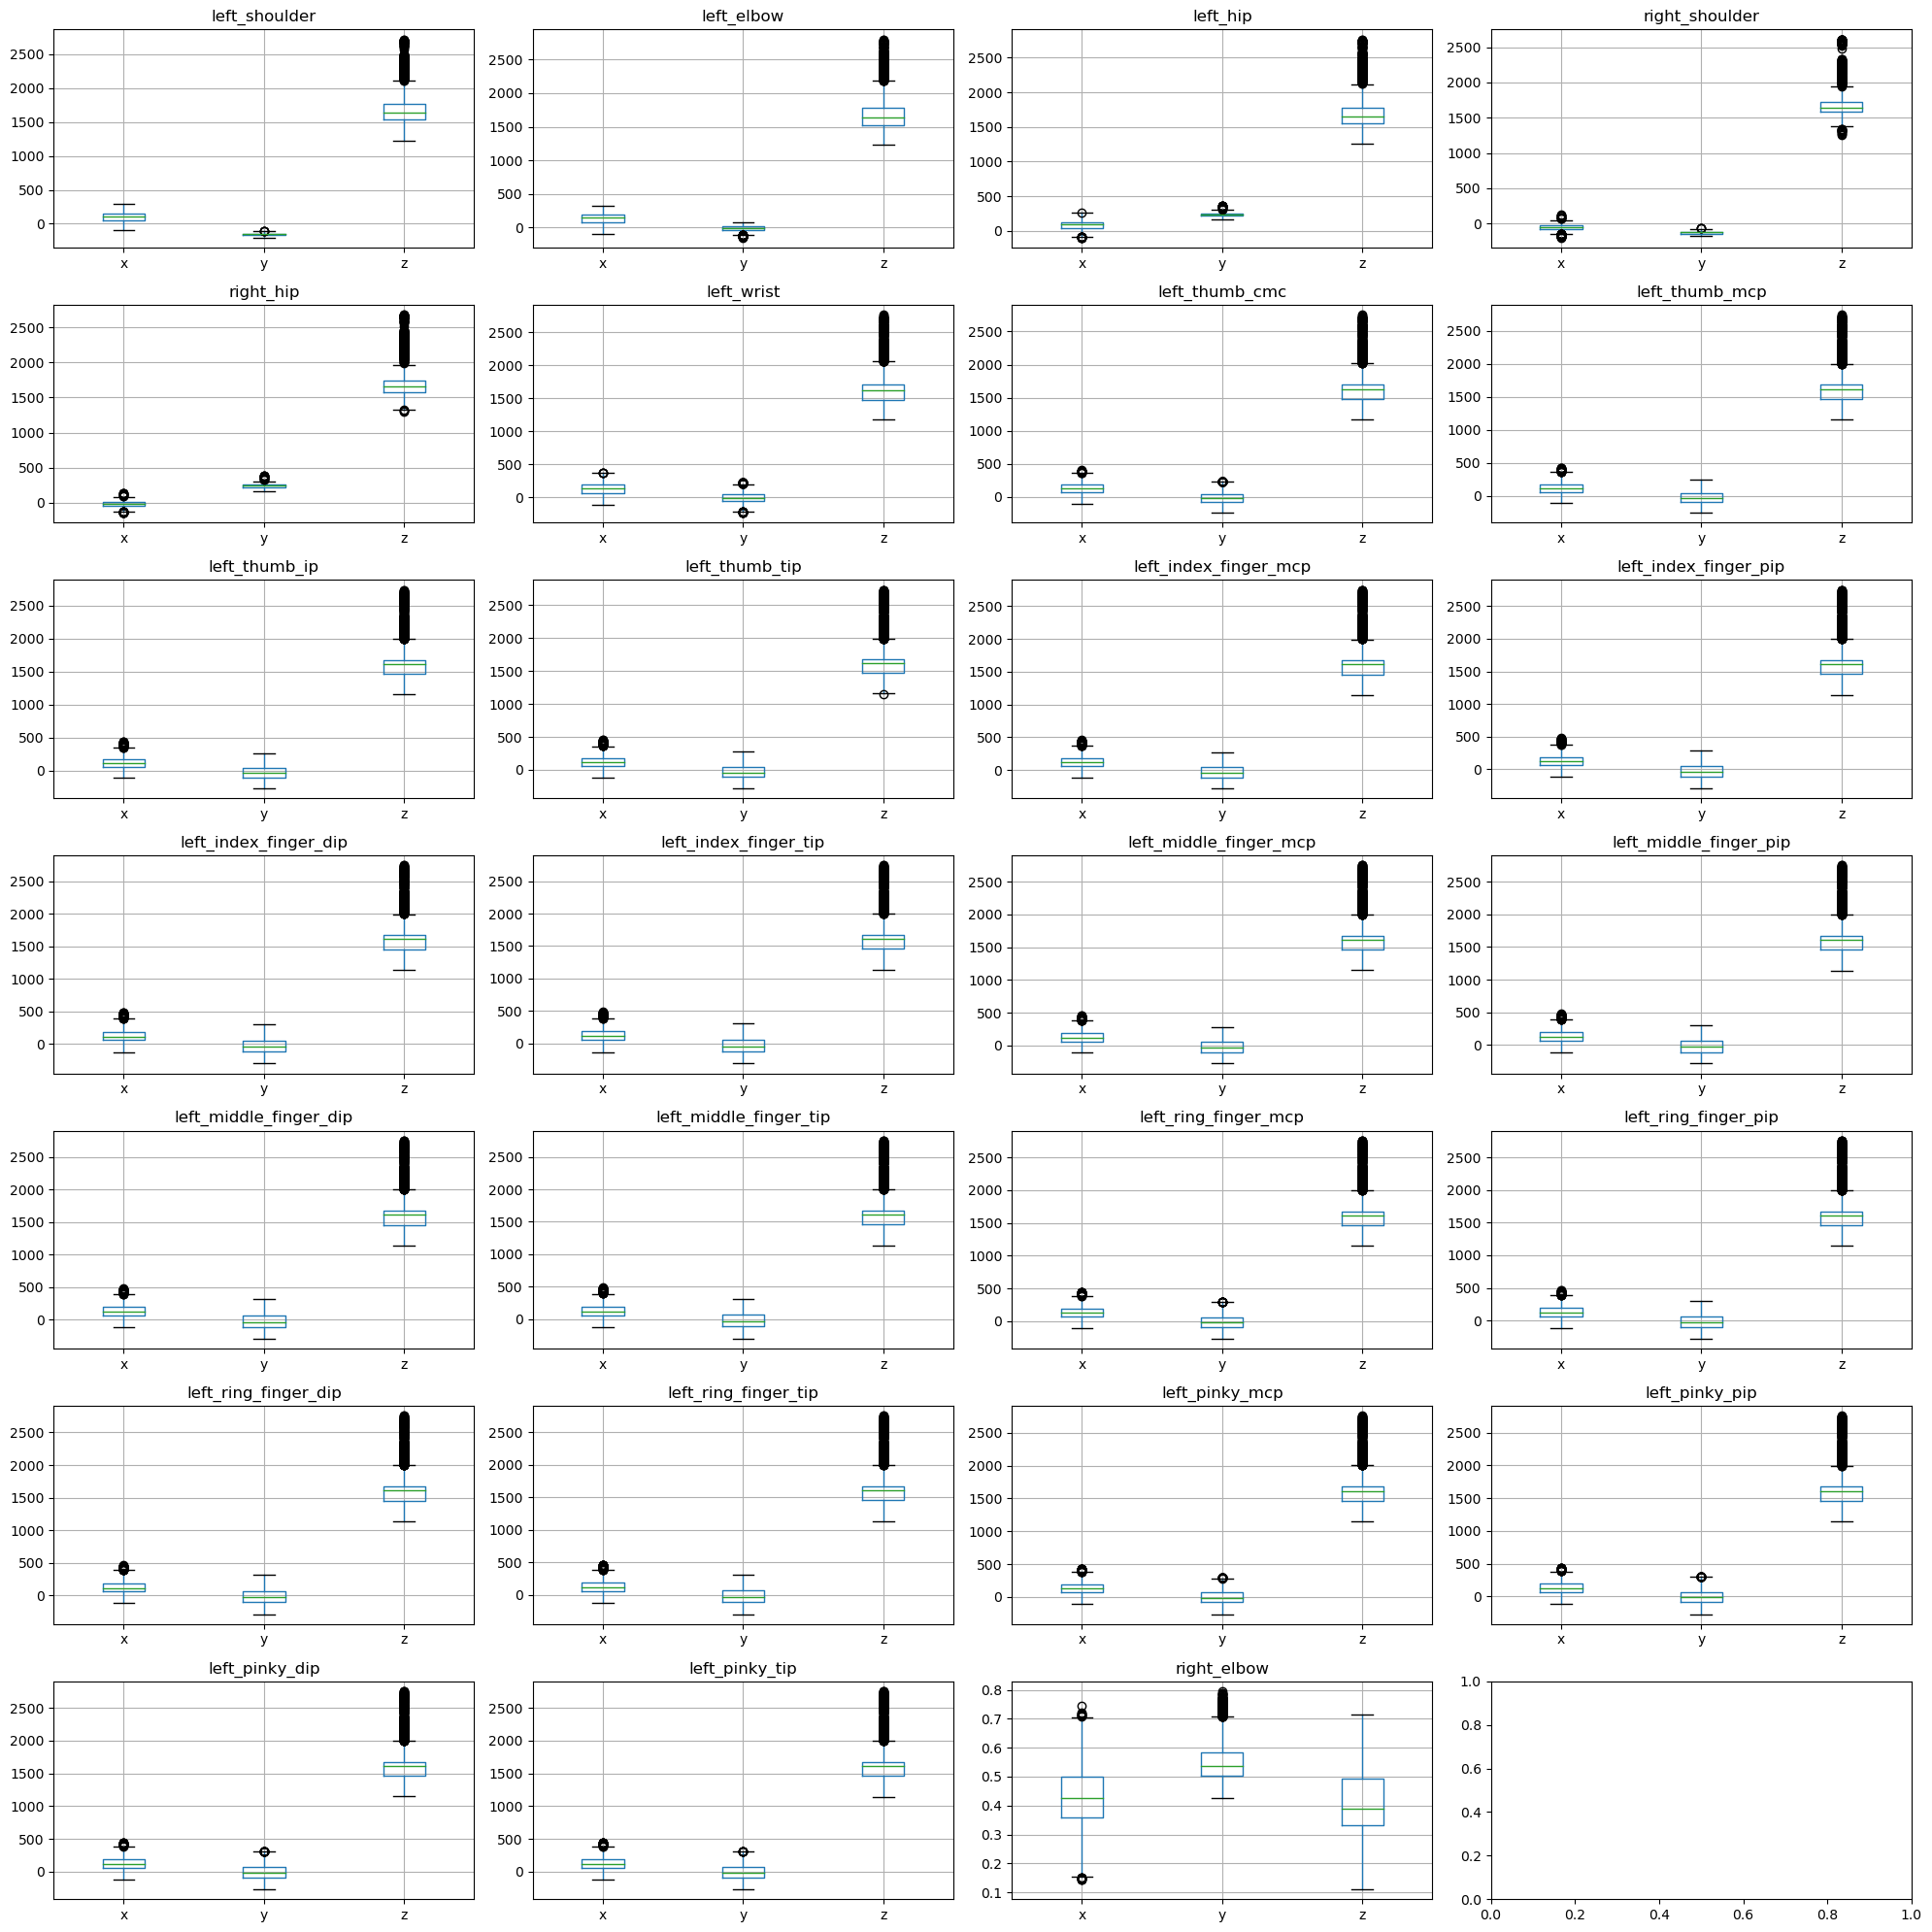

In [19]:
fig, axes = plt.subplots(7, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(len(arm_hand_fused_names)):
    ax = axes[i]
    df = pd.DataFrame(val_preds[:, i, :], columns=output_columns_name[:, i])
    df.boxplot(ax=ax)
    title = output_columns_name[:, i][0].split("_output")[0]
    ax.set_title(title)
    ax.set_xticklabels(["x", "y", "z"])

plt.tight_layout()
plt.show()

In [12]:
target_output = val_gt # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_left_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

In [20]:
target_output = ann_model(val_input).detach().to("cpu").numpy() # shape: (N, 144)  
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_left_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

KeyboardInterrupt: 

# Inspect test

In [41]:
test_input = test_dataset._inputs
test_input.shape

(1114, 288)

In [42]:
test_gt = test_dataset._outputs
test_gt = test_gt.reshape(-1, 3, 48)
test_gt = np.transpose(test_gt, (0, 2, 1))
test_gt.shape

(1114, 48, 3)

In [43]:
test_input = torch.Tensor(test_input)
test_input = test_input.to("cuda")
test_preds = ann_model(test_input)
test_preds = test_preds.detach().to("cpu").numpy()
test_preds = test_preds.reshape(-1, 3, 48)
test_preds = np.transpose(test_preds, (0, 2, 1))
test_preds.shape

(1114, 48, 3)

In [44]:
mae_of_first_26_joints = np.average(np.abs(test_gt[:, :26, :] - test_preds[:, :26, :]))
print("Mean abs. error of the first 26 joints: {}(mm)".format(round(mae_of_first_26_joints, 2)))

Mean abs. error of the first 26 joints: 17.51(mm)


In [47]:
test_preds = test_preds[:, :26, :]
print(test_preds.shape)

(1114, 26, 3)


In [48]:
test_gt = test_gt[:, :26, :]
print(test_gt.shape)

(1114, 26, 3)


In [49]:
pred_angles = []

for i in range(test_preds.shape[0]):
    test_pred = test_preds[i]
    test_pred_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
        test_pred,
        arm_hand_fused_names)
    
    left_arm_result = left_arm_angle_calculator(test_pred_XYZ_wrt_shoulder, 
        parent_coordinate=xyz_origin)
    left_arm_angles = left_arm_result["left_arm"]["angles"]
    left_arm_rot_mats_wrt_origin = left_arm_result["left_arm"]["rot_mats_wrt_origin"]
    last_coordinate_from_left_arm = left_arm_rot_mats_wrt_origin[-1]
    left_hand_result = left_hand_angle_calculator(test_pred_XYZ_wrt_shoulder, 
        parent_coordinate=last_coordinate_from_left_arm)
    
    left_hand_angles = []
    for finger_name in left_hand_angle_calculator.fingers_name:
        finger_i_angles = left_hand_result[finger_name]["angles"].copy()

        # In robot, its finger joint 1 is our finger joint 2, and vice versa (EXCEPT FOR THUMB FINGER). 
        # So that, we need to swap these values.
        if finger_name != "THUMB":
            finger_i_angles[0], finger_i_angles[1] = finger_i_angles[1], finger_i_angles[0]

        left_hand_angles.extend(finger_i_angles)
    
    angles = left_arm_angles.copy()
    angles.extend(left_hand_angles)    
    pred_angles.append(angles)

pred_angles = np.array(pred_angles)

In [50]:
gt_angles = []

for i in range(test_gt.shape[0]):
    gt = test_gt[i]
    test_gt_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
        gt,
        arm_hand_fused_names)
    
    left_arm_result = left_arm_angle_calculator(test_gt_XYZ_wrt_shoulder, 
        parent_coordinate=xyz_origin)
    left_arm_angles = left_arm_result["left_arm"]["angles"]
    left_arm_rot_mats_wrt_origin = left_arm_result["left_arm"]["rot_mats_wrt_origin"]
    last_coordinate_from_left_arm = left_arm_rot_mats_wrt_origin[-1]
    left_hand_result = left_hand_angle_calculator(test_gt_XYZ_wrt_shoulder, 
        parent_coordinate=last_coordinate_from_left_arm)
    
    left_hand_angles = []
    for finger_name in left_hand_angle_calculator.fingers_name:
        finger_i_angles = left_hand_result[finger_name]["angles"].copy()

        # In robot, its finger joint 1 is our finger joint 2, and vice versa (EXCEPT FOR THUMB FINGER). 
        # So that, we need to swap these values.
        if finger_name != "THUMB":
            finger_i_angles[0], finger_i_angles[1] = finger_i_angles[1], finger_i_angles[0]

        left_hand_angles.extend(finger_i_angles)
    
    angles = left_arm_angles.copy()
    angles.extend(left_hand_angles)    
    gt_angles.append(angles)

gt_angles = np.array(gt_angles)

In [51]:
angles_errors = np.mean(np.abs(gt_angles - pred_angles), axis=0)

In [52]:
angles_names = ["left_arm_joint_01",
                "left_arm_joint_02",
                "left_arm_joint_03",
                "left_arm_joint_04",
                "left_arm_joint_05",
                "left_arm_joint_06",
                "left_THUMB_joint_01",
                "left_THUMB_joint_02",
                "left_THUMB_joint_03",
                "left_INDEX_joint_01",
                "left_INDEX_joint_02",
                "left_INDEX_joint_03",
                "left_MIDDLE_joint_01",
                "left_MIDDLE_joint_02",
                "left_MIDDLE_joint_03",
                "left_RING_joint_01",
                "left_RING_joint_02",
                "left_RING_joint_03",
                "left_PINKY_joint_01",
                "left_PINKY_joint_02",
                "left_PINKY_joint_03"]

In [53]:
assert len(angles_names) == len(angles_errors)

for joint_error, joint_name in zip(angles_errors, angles_names):
    print(f"{joint_name} mean error: {round(joint_error, 2)}")

left_arm_joint_01 mean error: 7.88
left_arm_joint_02 mean error: 8.21
left_arm_joint_03 mean error: 22.49
left_arm_joint_04 mean error: 9.95
left_arm_joint_05 mean error: 47.9
left_arm_joint_06 mean error: 13.42
left_THUMB_joint_01 mean error: 14.81
left_THUMB_joint_02 mean error: 17.03
left_THUMB_joint_03 mean error: 6.85
left_INDEX_joint_01 mean error: 14.69
left_INDEX_joint_02 mean error: 17.73
left_INDEX_joint_03 mean error: 22.85
left_MIDDLE_joint_01 mean error: 16.8
left_MIDDLE_joint_02 mean error: 22.12
left_MIDDLE_joint_03 mean error: 27.35
left_RING_joint_01 mean error: 18.25
left_RING_joint_02 mean error: 23.08
left_RING_joint_03 mean error: 28.47
left_PINKY_joint_01 mean error: 19.52
left_PINKY_joint_02 mean error: 27.18
left_PINKY_joint_03 mean error: 25.69


In [30]:
target_output = test_preds # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_left_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()